# PA1 ML workflow and decision tree

### Group members:

- Isac Snecker
- Isak Söderlind
- Simon Westlin Green


# Task 1: A classification example: fetal heart condition diagnosis


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

LOCATION_OF_THE_FILE = "./CTG.csv"

# Read the CSV file.
data = pd.read_csv(LOCATION_OF_THE_FILE, skiprows=1)

# Select the relevant numerical columns.
selected_cols = [
    "LB",
    "AC",
    "FM",
    "UC",
    "DL",
    "DS",
    "DP",
    "ASTV",
    "MSTV",
    "ALTV",
    "MLTV",
    "Width",
    "Min",
    "Max",
    "Nmax",
    "Nzeros",
    "Mode",
    "Mean",
    "Median",
    "Variance",
    "Tendency",
    "NSP",
]
data = data[selected_cols].dropna()

# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X = data_shuffled.drop("NSP", axis=1)


# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, "normal", "suspect", "pathologic"][(int(y))]


Y = data_shuffled["NSP"].apply(to_label)

# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)
X.head()


,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
658,130.0,1.0,0.0,3.0,0.0,0.0,0.0,24.0,1.2,12.0,...,35.0,120.0,155.0,1.0,0.0,134.0,133.0,135.0,1.0,0.0
1734,134.0,9.0,1.0,8.0,5.0,0.0,0.0,59.0,1.2,0.0,...,109.0,80.0,189.0,6.0,0.0,150.0,146.0,150.0,33.0,0.0
1226,125.0,1.0,0.0,4.0,0.0,0.0,0.0,43.0,0.7,31.0,...,21.0,120.0,141.0,0.0,0.0,131.0,130.0,132.0,1.0,0.0
1808,143.0,0.0,0.0,1.0,0.0,0.0,0.0,69.0,0.3,6.0,...,27.0,132.0,159.0,1.0,0.0,145.0,144.0,146.0,1.0,0.0
825,152.0,0.0,0.0,4.0,0.0,0.0,0.0,62.0,0.4,59.0,...,25.0,136.0,161.0,0.0,0.0,159.0,156.0,158.0,1.0,1.0


In [2]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy="most_frequent")

from sklearn.model_selection import cross_val_score

cross_val_score(clf, Xtrain, Ytrain)


array([0.78235294, 0.78235294, 0.77941176, 0.77941176, 0.77941176])

In [3]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Test each classifier and print the mean cross-validation score.
for classifier in (
    GradientBoostingClassifier,
    RandomForestClassifier,
    Perceptron,
    LinearSVC,
    DecisionTreeClassifier,
):
    clf = classifier()
    print(f"{clf} {cross_val_score(clf, Xtrain, Ytrain)}")


GradientBoostingClassifier() [0.94411765 0.96176471 0.94411765 0.94411765 0.95294118]
RandomForestClassifier() [0.93529412 0.95       0.93529412 0.92647059 0.95      ]
Perceptron() [0.84705882 0.88529412 0.82941176 0.85294118 0.71176471]
LinearSVC() [0.88529412 0.92058824 0.86764706 0.89705882 0.90882353]
DecisionTreeClassifier() [0.90882353 0.94117647 0.91764706 0.90588235 0.93529412]


Highest mean are GradientBoostingClassifier, RandomForestClassifier and DecisionTreeClassifier

GradientBoostingClassifier: [0.94117647 0.96470588 0.94411765 0.94411765 0.95294118]

RandomForestClassifier: [0.93529412 0.95294118 0.93529412 0.93235294 0.94411765]

DecisionTreeClassifier: [0.90588235 0.94117647 0.91176471 0.9 0.94411765]


In [4]:
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier()
clf.fit(Xtrain, Ytrain)
Yguess = clf.predict(Xtest)

print("Accuracy: ", accuracy_score(Ytest, Yguess))


Accuracy:  0.9295774647887324


The selected model Gradient Boosting Classifier is an ensamble model. This means it uses a collection of multiple decision trees.

The given accuracy for GradientBoostingClassifier is: 0.92957746


# Task 2: Decision trees for classification


In [5]:
class DecisionTreeLeaf:
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = (
            f"{self.value:.4g}" if isinstance(self.value, float) else str(self.value)
        )
        graph.node(node_id, val_str, style="filled")
        return node_counter + 1, node_id

    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False


In [6]:
class DecisionTreeBranch:
    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f"F{self.feature}" if names is None else names[self.feature]
        lbl = f"{fname} > {self.threshold:.4g}?"
        graph.node(
            node_id, lbl, shape="box", fillcolor="yellow", style="filled, rounded"
        )
        graph.edge(node_id, low_id, "False")
        graph.edge(node_id, high_id, "True")
        return node_counter + 1, node_id


In [7]:
from abc import ABC, abstractmethod

import numpy as np
from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin


class DecisionTree(ABC, BaseEstimator):
    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth

    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)
        self.root = self.make_tree(X, Y, self.max_depth)

    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph

    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)

    # This is the recursive training
    def make_tree(self, X, Y, max_depth):
        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(
            self.best_split(X, Y, feature) for feature in range(n_features)
        )

        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(
            X, Y, best_feature, best_threshold
        )

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth - 1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth - 1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(
            best_feature, best_threshold, low_subtree, high_subtree
        )

    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:, feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]

    # The following three methods need to be implemented by the classification and regression subclasses.

    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass


In [8]:
from collections import Counter

In [9]:
def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high


def entropy(distr):
    n = sum(distr.values())
    ps = [n_i / n for n_i in distr.values()]
    return -sum(p * np.log2(p) if p > 0 else 0 for p in ps)


def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low * entropy(low_distr) + n_high * entropy(high_distr)) / (
        n_low + n_high
    )


def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i / n for n_i in distr.values()]
    return 1 - sum(p**2 for p in ps)


def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low * gini_impurity(low_distr) + n_high * gini_impurity(high_distr)) / (
        n_low + n_high
    )


class TreeClassifier(DecisionTree, ClassifierMixin):
    def __init__(self, max_depth=10, criterion="maj_sum"):
        super().__init__(max_depth)
        self.criterion = criterion

    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == "maj_sum":
            self.criterion_function = majority_sum_scorer
        elif self.criterion == "info_gain":
            self.criterion_function = info_gain_scorer
        elif self.criterion == "gini":
            self.criterion_function = gini_scorer
        else:
            raise Exception(f"Unknown criterion: {self.criterion}")
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]

    # Checks whether a set of output values is homogeneous. In the classification case,
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1

    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):
        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n - 1):
            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]

            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            # x_next = XY[i+1][0]
            x_next = X_sorted[i + 1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i + 1, low_distr, n - i - 1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5 * (X_sorted[max_i] + X_sorted[max_i + 1])
        return max_score, feature, split_point


In [10]:
best = -1
best_depth = -1

for depth in range(1, 26):
    clf = TreeClassifier(max_depth=depth)
    scores = cross_val_score(clf, Xtrain, Ytrain)
    print(f"Depth: {depth} Scores: {scores} Mean: {scores.mean(): .4f}")
    if scores.mean() > best:
        best = scores.mean()
        best_depth = depth

print(f"Best depth: {best_depth} with mean score {best:.4f}")


Depth: 1 Scores: [0.84411765 0.83823529 0.84411765 0.81176471 0.82058824] Mean:  0.8318
Depth: 2 Scores: [0.90588235 0.90882353 0.88529412 0.87941176 0.87647059] Mean:  0.8912
Depth: 3 Scores: [0.91764706 0.91764706 0.89411765 0.88823529 0.88529412] Mean:  0.9006
Depth: 4 Scores: [0.92941176 0.92058824 0.91176471 0.89411765 0.9       ] Mean:  0.9112
Depth: 5 Scores: [0.92941176 0.91764706 0.91176471 0.89117647 0.89705882] Mean:  0.9094
Depth: 6 Scores: [0.92647059 0.92352941 0.90882353 0.89117647 0.89705882] Mean:  0.9094
Depth: 7 Scores: [0.92647059 0.92352941 0.90882353 0.89705882 0.89705882] Mean:  0.9106
Depth: 8 Scores: [0.92647059 0.92647059 0.9        0.89117647 0.89705882] Mean:  0.9082
Depth: 9 Scores: [0.92352941 0.93235294 0.90294118 0.9        0.89705882] Mean:  0.9112
Depth: 10 Scores: [0.92058824 0.92941176 0.91176471 0.9        0.9       ] Mean:  0.9124
Depth: 11 Scores: [0.92352941 0.92941176 0.91176471 0.9        0.9       ] Mean:  0.9129
Depth: 12 Scores: [0.91470588 

The best depth is 13 with a mean score of 0.9171


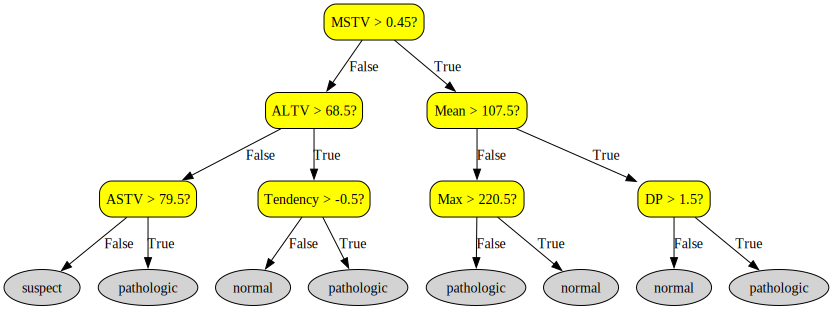

In [11]:
clf = TreeClassifier(max_depth=3)
clf.fit(Xtrain, Ytrain)
graph = clf.draw_tree()
graph


# Task 3: A regression example: predicting property prices


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the Excel file using Pandas.
alldata = pd.read_excel("Hemnet_data.xlsx")

# # Convert the timestamp string to an integer representing the year.
alldata["year"] = pd.DatetimeIndex(alldata["Sold Date"]).year

# Convert 'yes' to 1 and 'no' to 0
alldata["Balcony"] = alldata["Balcony"].str.lower().map({"yes": 1, "no": 0})
alldata["Patio"] = alldata["Patio"].str.lower().map({"yes": 1, "no": 0})
alldata["Lift"] = alldata["Lift"].str.lower().map({"yes": 1, "no": 0})

# Select the 12 input columns and the output column.
selected_columns = [
    "Final Price (kr)",
    "year",
    "Num of Room",
    "Living Area (m²)",
    "Balcony",
    "Patio",
    "Current Floor",
    "Total Floor",
    "Lift",
    "Built Year",
    "Fee (kr/month)",
    "Operating Fee (kr/year)",
]
alldata = alldata[selected_columns]

# NOTE This had to be added because we have some non-numeric values in the Fee column.
alldata["Fee (kr/month)"] = (
    alldata["Fee (kr/month)"]
    .astype(str)
    .str.replace("kr", "", case=False)
    .str.replace(" ", "")
)
alldata["Fee (kr/month)"] = pd.to_numeric(alldata["Fee (kr/month)"], errors="coerce")
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop("Final Price (kr)", axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled["Final Price (kr)"].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)


In [13]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

classifiers = (
    LinearRegression,
    Ridge,
    Lasso,
    DecisionTreeRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
    MLPRegressor,
)

# Test each classifier and print the mean cross-validation score.
for classifier in classifiers:
    clf = classifier()
    print(
        f"{clf} {cross_validate(clf, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'].mean()}"
    )


LinearRegression() -0.22044055517560865
Ridge() -0.22043967992162883
Lasso() -0.2791880396320781
DecisionTreeRegressor() -0.28212699258704543
RandomForestRegressor() -0.1491539697920879
GradientBoostingRegressor() -0.1579296896291374
MLPRegressor() -22.367706080504664


The RandomForestRegressor performs the best with nmse around -0.148.

The GradientBoosting performs around -0.158.

All of the models we tried were: LinearRegression, Ridge, Lasso, DecisionTreeRegressor and MLPRegressor. The MPLRegressor by far performed worst.

Because it had the lowest score we use RandomForestRegressor for further evaluation.


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

regr = RandomForestRegressor()
regr.fit(Xtrain, Ytrain)
mean_squared_error(Ytest, regr.predict(Xtest))


0.13448622537194277

Our final mse is around 0.13449
